# 1. Imports

In [247]:
import pandas  as pd
import numpy   as np
import pickle  as pkl

### Graph
import matplotlib.pyplot as plt
import seaborn           as sns
from   matplotlib.gridspec import GridSpec
from   IPython.display import Image


### A/B Libs
import RSLib.Utilities as rsl
from scipy.stats import mannwhitneyu, shapiro, ttest_ind


### 
from statsmodels.stats import api as sms

### Supressão de notações científicas
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# Funções de apoio

In [248]:
def analise_por_pais(data_raw, pais):
    ### Filtragem dos dados
    df = data_raw[data_raw.country == pais]

########### ------------------------ Dispersão das variáveis candidatas ------------------------###########

    ### Análise estatística
    display( df.groupby( 'group' ).agg(
        {
            'country'   : 'count',
            'spent'     : ['min', 'max', 'mean', 'std'],
            'purchases' : ['min', 'max', 'mean', 'std'],
        }
    ) )


########### ------------------------ Quantidade por gênero e Dispositivo ------------------------###########

    ### Configuração dimensionamento plotagem gráfica
    sns.set( rc = {'figure.figsize' : (35,30) } )

    grid = GridSpec( 4,2 )

    ### Análise por gênero
    ## Gráfico 01
    plt.subplot( grid[0,0] )
    ax = sns.countplot(
        data    = df,
        x       = 'gender',    
        palette = 'BrBG' 
    )
    plt.title( 'Quantidade geral por gênero' , x = 0.1)
    plt.xlabel( 'Gênero' )
    plt.ylabel( 'Quantidade' )
    rsl.plot_grafico.plot_values_vbar(ax);

    ## Gráfico 02
    plt.subplot(grid[0,1])
    ax = sns.countplot(
        data    = df,
        x       = 'group',
        hue     = 'gender',
        palette = 'BrBG' 
    )
    plt.title( 'Quantidade de amostras de cada gênero por grupo' , x = 0.17)
    plt.xlabel( 'Grupo' )
    plt.ylabel( 'Quantidade' )
    ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
    plt.legend( ['Masc', 'Fem'] )
    rsl.plot_grafico.plot_values_vbar(ax)


    # --- Coluna 02 --- #

    ### Análise por dispositivo
    ## Gráfico 03
    plt.subplot( grid[1,0] )
    ax = sns.countplot(
        data    = df,
        x       = 'device',
        palette = 'OrRd' 
    )
    plt.title( 'Quantidade geral por Dispositivo' , x = 0.11)
    plt.xlabel( 'Gênero' )
    plt.ylabel( 'Quantidade' )
    ax.set_xticklabels( ['Aplicativo', 'Navegador'] )
    rsl.plot_grafico.plot_values_vbar(ax)


    ## Gráfico 04
    plt.subplot( grid[1,1] )
    ax = sns.countplot(
        data    = df,
        x       = 'group',
        hue     = 'device',
        palette = 'OrRd' 
    )
    plt.title( 'Quantidade de amostras de cada dispositivo por Grupo' , x = 0.18)
    plt.xlabel( 'Grupo' )
    plt.ylabel( 'Quantidade' )
    plt.legend( ['Aplicativo', 'Navegador'] )
    ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
    rsl.plot_grafico.plot_values_vbar(ax);

########### ------------------------ Variação das variáveis candidatas ------------------------###########    
    ### Plotagem gráfica
    # Gráfico 01
    plt.subplot(grid[2,0])
    ax = sns.boxenplot(
        data = df,
        x = 'group',
        y = 'spent',
        palette = 'OrRd' 

    )
    plt.title( 'Gastos por Grupo' , x = 0.08)
    plt.xlabel( 'Grupo' )
    plt.ylabel( 'Gastos' )
    ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
    # Gráfico 02
    plt.subplot(grid[2,1])
    ax = sns.boxenplot(
        data = df,
        x = 'group',
        y = 'purchases',
        palette = 'OrRd' 

    )
    plt.title( 'Compras por Grupo' , x = 0.09)
    plt.xlabel( 'Grupo' )
    plt.ylabel( 'Compras' )
    ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] );

########### ------------------------ Dispersão das distribuições  ------------------------###########
    

    ###Separação dos dados por grupo
    ga = df.loc[df.group == 'GRP A', ['spent', 'purchases']]
    gb = df.loc[df.group == 'GRP B', ['spent', 'purchases']]

    ### Plotagem gráfica
    # Gráfico 01
    plt.subplot(grid[3,0])
    plt.hist(
        x = ga['spent'],
        color = 'darkolivegreen'
    )
    plt.hist(
        x = gb['spent'],
        color='bisque',
        alpha = 0.65
    )
    plt.title( 'Distribuição de Gastos', x = 0.11 )
    plt.xlabel( 'Gastos' )
    plt.ylabel( 'Quantidade' )
    plt.legend( ['Grupo A', 'Grupo B'] )

    # Gráfico 02
    plt.subplot(grid[3,1])
    plt.hist(
        x = ga['purchases'],
        color = 'salmon'
    )
    plt.hist(
        x = gb['purchases'],
        color='bisque',
        alpha = 0.65
    )
    plt.title( 'Distribuição de Compras', x = 0.11 )
    plt.xlabel( 'Compras' )
    plt.ylabel( 'Quantidade' )
    plt.legend( ['Grupo A', 'Grupo B'] );


def normalidade_amostral(data_raw, pais, grupos):
        '''
        Teste de normalidade de distribuição
        '''
        t_test, pvalue = shapiro( data_raw[ ( data_raw.country == pais ) & (  data_raw.group == grupos[0]  ) ].spent )
        if pvalue > 0.05:
            print( 'Distribuição da amostra do grupo A é normal' )
        else:
            print( 'Distribuição da amostra do grupo A não é normal' )


        t_test, pvalue = shapiro( data_raw[ ( data_raw.country == pais ) & (  data_raw.group == grupos[1]  ) ].spent )
        if pvalue > 0.05:
            print( 'Distribuição da amostra do grupo B é normal' )
        else:
            print( 'Distribuição da amostra do grupo B não é normal' ) 


# 2. Dados

In [249]:
data_raw       = pkl.load( open( '../models/data_raw.sav', 'rb' ) )
df_control   = pkl.load( open( '../models/df_control.sav', 'rb' ) )
df_treatment = pkl.load( open( '../models/df_treatment.sav', 'rb' ) )

# 3. Design do experimento

    - Definição do objetivo  : Validar se a nova ferramenta de preenchimento automático é efetivamente melhor do que o preenchimento manual;
    - Definição das métricas : Segundo Gauss, a quantidade amostral está inversamente relacionada a variabilidade (desvio padrão) dos dados. 
      Com base nessa análise, em segundo cíclo, será analisado o faturamento ('spent') para definir o sucesso do experimento que é o preço/número de vendas (GMV); 

-- Nota -- <br/>
-Grupo A (Treatment) = Preenchimento automático;<br/>
-Grupo B (Control)   = Preenchimento manual;

## 3.1 Definição das métricas

In [250]:
'''
Antes de aplicar a fórmula para calcular o tamanho da amostra, teremos que definir o tamanho do efeito (effect_size). E para isso temos que delimitar:
- Métrica inicial(metric_ini) = Seria a média de GMV geral da amostra ou a média das vendas;
- Métrica final(metric_fin)   = Seria a métrica inicial mais(+) o lift (referente ao tamanho do efeito que pretende-se analisar);
- Desvio padrão(std_metric)   = Diferênça entre as médias dos grupos.
Assim, podemos calcular o effect_size: 
- effect_size = ( metric_fin - metric_ini ) / std_metric
'''
### Como foi constatado na EDA 1º cíclo que a diferença dos grupos de modo geral é muito pequena, será analisado as amostras por país onde foram detectados pequenas diferênças.

## Dataframe auxiliar contendo média e desvio padrão dos dados referentes ao Brasil
df_aux = data_raw.loc[data_raw.country == 'USA'].spent.agg( ['mean', 'std'] )

## A métrica inicial receberá a média dos gastos referente a toda a amostra
metric_ini = df_aux['mean']
## A métrica final receberá a média dos gastos mais a margem (lift) de 5%
metric_fin = metric_ini * 1.05
## Desvio padrão referente a toda a amostra de dados
std_metric = df_aux['std']

## Cálculo do tamanho do efeito
effect_size = ( metric_fin - metric_ini ) / std_metric
print( f'Média do GMV:        {metric_ini:.5}' )
print( f'Média do GMV + lift: {metric_fin:.5}' )
print( f'Desvio padrão:       {std_metric:.5}' )
print( f'Tamanho do efeito:   {effect_size:.3}' )

Média do GMV:        1876.4
Média do GMV + lift: 1970.3
Desvio padrão:       1358.2
Tamanho do efeito:   0.0691


In [251]:
'''
Para aplicação da fórmula, utilizaremos uma função da biblioteca statsmodels. Para essa função, deve-se passar:
- efect_size
- alpha 
- power

'''
sample_size = sms.tt_ind_solve_power(
    effect_size = effect_size,
    alpha = 0.05,
    power = 0.80
)
total_amostra = len( data_raw[data_raw.country == 'USA'] )

print( f'Total amostral ----------------------- { total_amostra }' )
print( f'Tamanho mínimo de amostra por grupo -- {np.ceil( sample_size ).astype( int )}' )
print( f'Tamanho mínimo de amostra geral ------ {np.ceil( 2*sample_size ).astype( int )}' )

Total amostral ----------------------- 13998
Tamanho mínimo de amostra por grupo -- 3291
Tamanho mínimo de amostra geral ------ 6582


    O que será encapsulado na RSLib para permitir a reprodutibilidade

In [252]:
### Chamada da função encapsulada utilizando 'np.ceil' apenas para arredondar o número
sample_size, real_size = np.ceil(
    rsl.ab_testing.calculo_tamanho_amostra(
    data_raw = data_raw,
    pais = 'BRA',
    indicador = 0
)
).astype(int)
print( f'Tamanho real da amostra   : {real_size}' )
print( f'Total mínimo de amostra   : {sample_size * 2}' )
print( f'Tamanho amostral por grupo: {sample_size }' )

Tamanho real da amostra   : 9009
Total mínimo de amostra   : 6790
Tamanho amostral por grupo: 3395


# 4. Hipóteses do experimento

    H0 = A média de GMV do grupo A e B, são iguais (avg GMV == avg GMV B)
    H1 = A média de GMV dos dois grupos são diferentes

# 5. Preparação dos dados

    Para esta etapa, focaremos nos resultados dos países separadamente

## 5.1 Brasil

### 5.1.1 Estatística deescritiva

     Nessa etapa, será checada a homogeneidade dos dados amostrais do Brasil

In [253]:
### Filtrando os dados
df_br = data_raw[data_raw.country == 'BRA']

In [254]:
#Detecção de valores nulos
df_br.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [255]:
#Visualização geral dos dados e sua distribuição
display( df_br.head(2) )
display( df_br.describe().T )

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A


,count,mean,std,min,25%,50%,75%,max
uid,9009.00,55722867.56,25669807.88,11143138.00,33428113.00,55869561.00,78131055.00,99996986.00
spent,9009.00,1902.86,1398.89,99.00,897.00,1596.00,2593.00,10480.00
purchases,9009.00,4.58,3.15,1.00,2.00,4.00,6.00,24.00


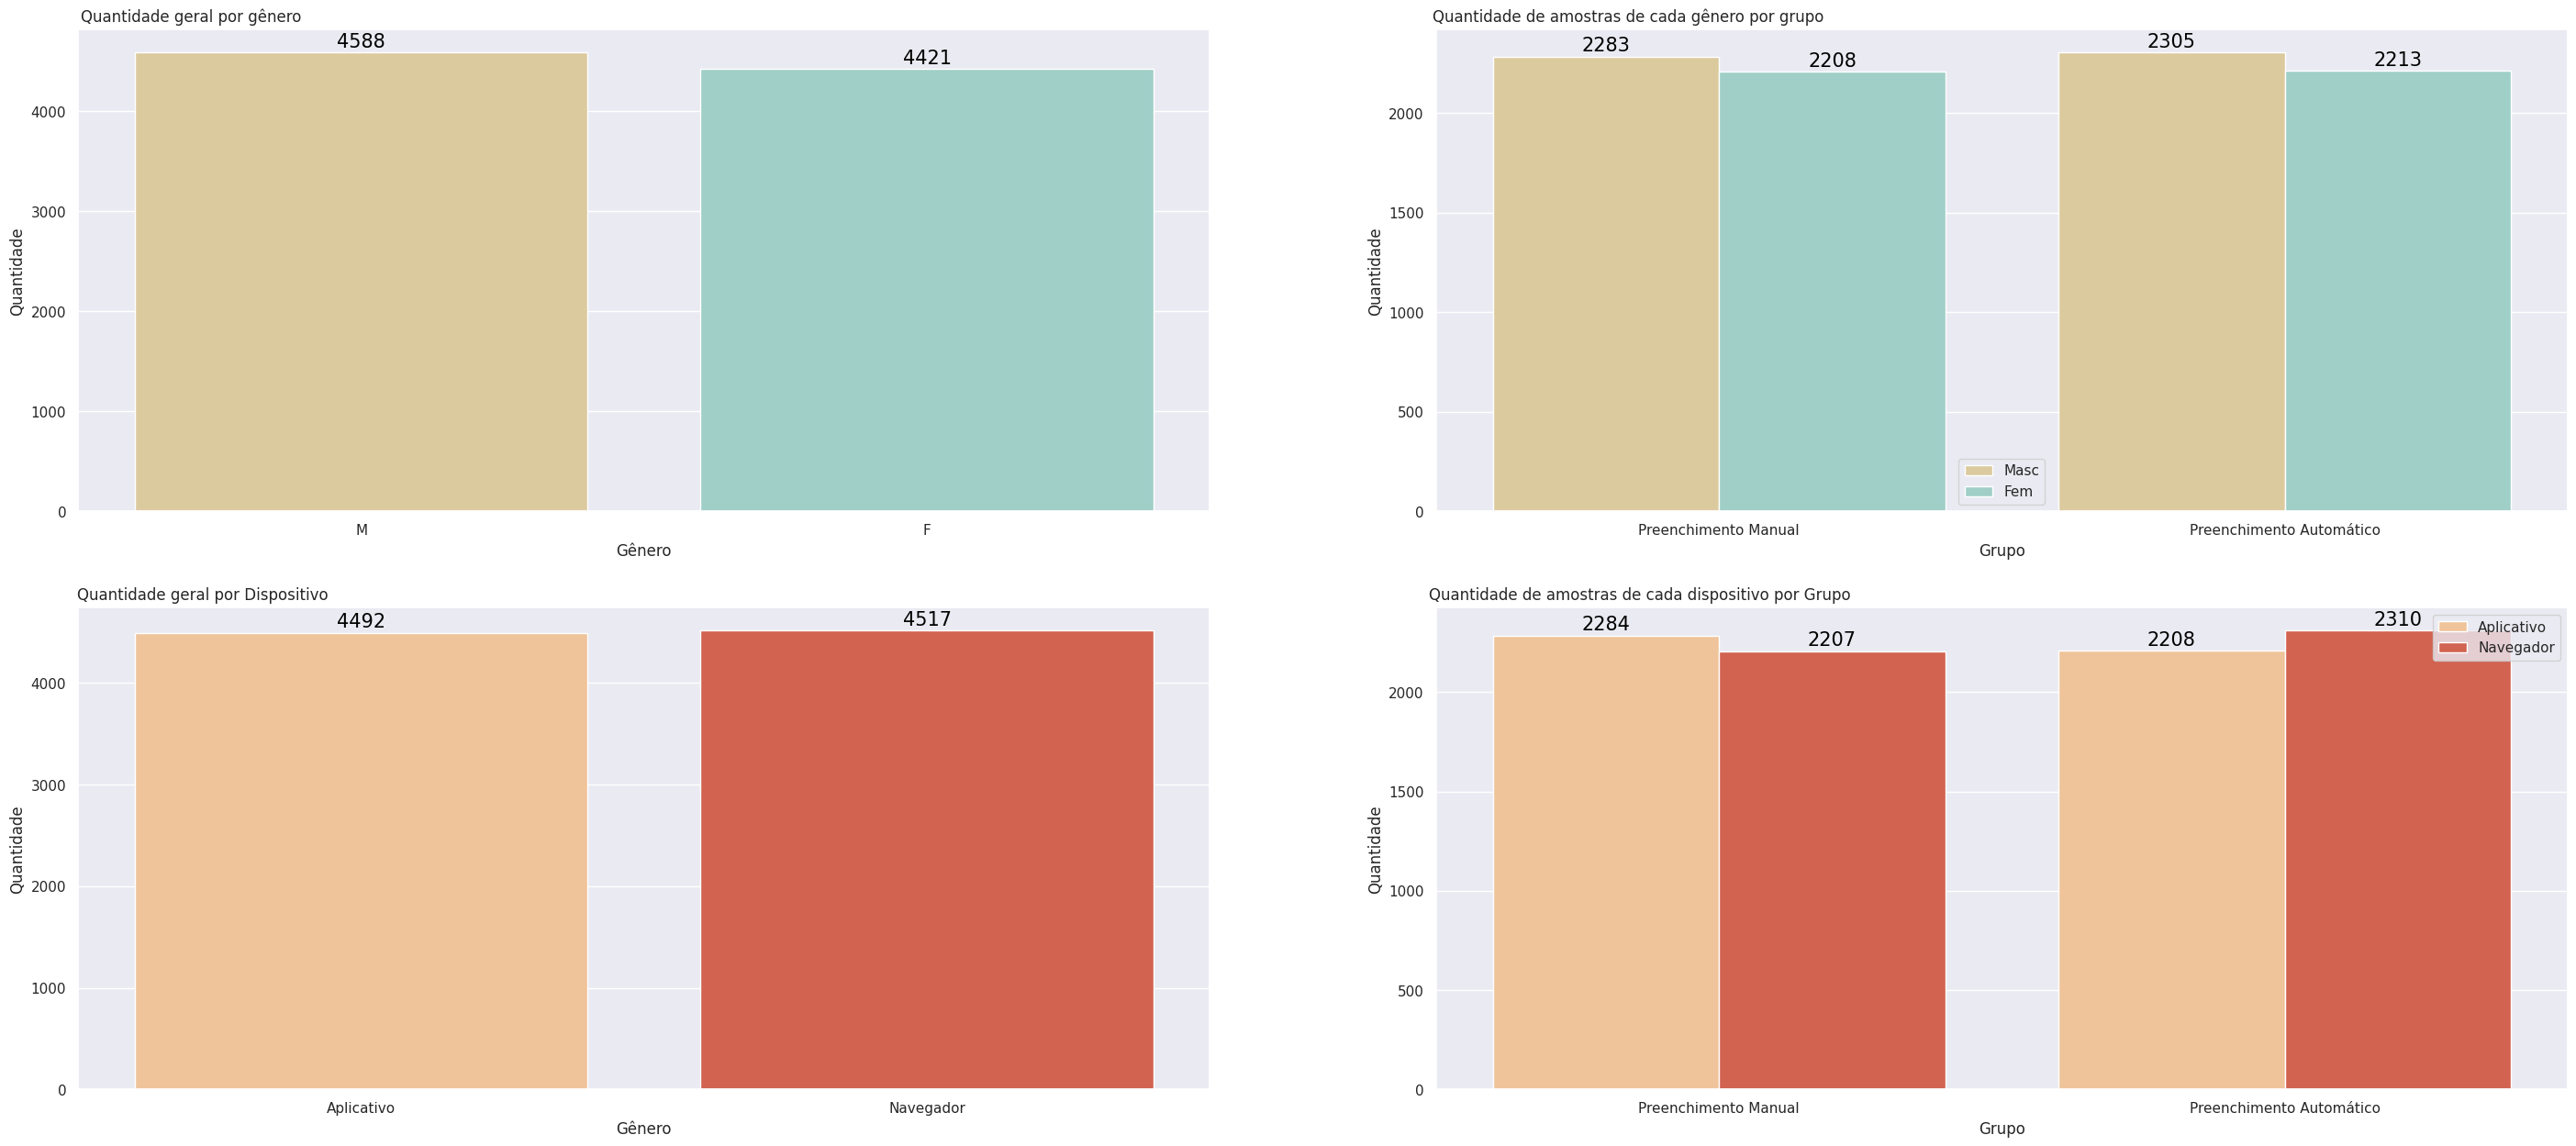

In [256]:
### Configuração dimensionamento plotagem gráfica
sns.set( rc = {'figure.figsize' : (35,15) } )

grid = GridSpec( 2,2 )
### Análise por gênero
## Gráfico 01
plt.subplot( grid[0,0] )
ax = sns.countplot(
    data    = df_br,
    x       = 'gender',    
    palette = 'BrBG' 
)
plt.title( 'Quantidade geral por gênero' , x = 0.1)
plt.xlabel( 'Gênero' )
plt.ylabel( 'Quantidade' )
rsl.plot_grafico.plot_values_vbar(ax);

## Gráfico 02
plt.subplot(grid[0,1])
ax = sns.countplot(
    data    = df_br,
    x       = 'group',
    hue     = 'gender',
    palette = 'BrBG' 
)
plt.title( 'Quantidade de amostras de cada gênero por grupo' , x = 0.17)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Quantidade' )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
plt.legend( ['Masc', 'Fem'] )
rsl.plot_grafico.plot_values_vbar(ax)


# --- Coluna 02 --- #

### Análise por dispositivo
## Gráfico 03
plt.subplot( grid[1,0] )
ax = sns.countplot(
    data    = df_br,
    x       = 'device',
    palette = 'OrRd' 
)
plt.title( 'Quantidade geral por Dispositivo' , x = 0.11)
plt.xlabel( 'Gênero' )
plt.ylabel( 'Quantidade' )
ax.set_xticklabels( ['Aplicativo', 'Navegador'] )
rsl.plot_grafico.plot_values_vbar(ax)


## Gráfico 04
plt.subplot( grid[1,1] )
ax = sns.countplot(
    data    = df_br,
    x       = 'group',
    hue     = 'device',
    palette = 'OrRd' 
)
plt.title( 'Quantidade de amostras de cada dispositivo por Grupo' , x = 0.18)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Quantidade' )
plt.legend( ['Aplicativo', 'Navegador'] )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
rsl.plot_grafico.plot_values_vbar(ax);



country spent                        purchases              
        count   min    max    mean     std       min max mean  std
group                                                             
GRP A    4518    99  10480 1899.79 1413.07         1  24 4.57 3.17
GRP B    4491    99  10478 1905.95 1384.62         1  23 4.59 3.13

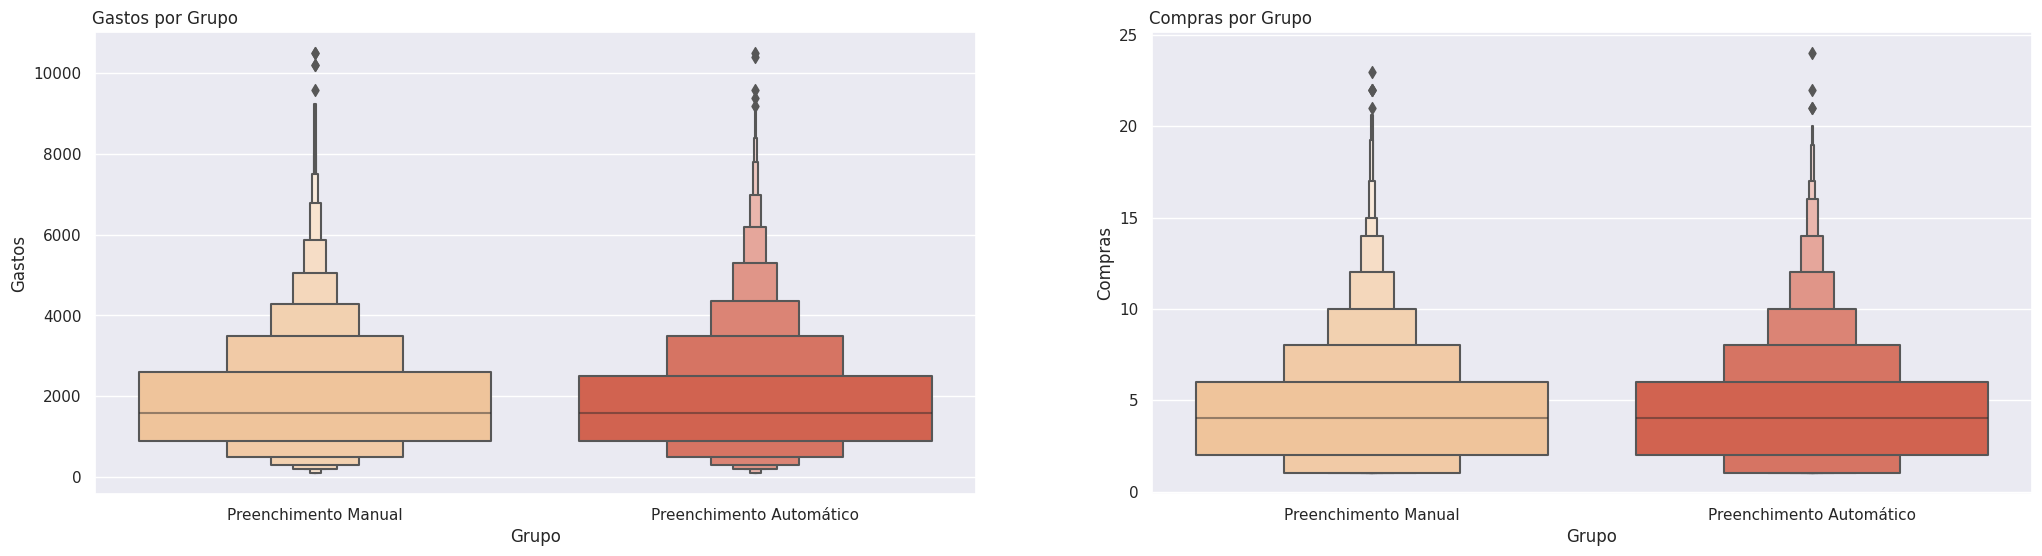

In [257]:
### Variação das variáveis candidatas

### Análise estatística
display( df_br.groupby( 'group' ).agg(
    {
        'country'   : 'count',
        'spent'     : ['min', 'max', 'mean', 'std'],
        'purchases' : ['min', 'max', 'mean', 'std'],
    }
) )

### Plotagem gráfica
grid = GridSpec(1,2)
sns.set( rc = {'figure.figsize' : (25,6)} )
# Gráfico 01
plt.subplot(grid[0,0])
ax = sns.boxenplot(
    data = df_br,
    x = 'group',
    y = 'spent',
    palette = 'OrRd' 

)
plt.title( 'Gastos por Grupo' , x = 0.08)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Gastos' )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] )
# Gráfico 02
plt.subplot(grid[0,1])
ax = sns.boxenplot(
    data = df_br,
    x = 'group',
    y = 'purchases',
    palette = 'OrRd' 

)
plt.title( 'Compras por Grupo' , x = 0.09)
plt.xlabel( 'Grupo' )
plt.ylabel( 'Compras' )
ax.set_xticklabels( ['Preenchimento Manual', 'Preenchimento Automático'] );

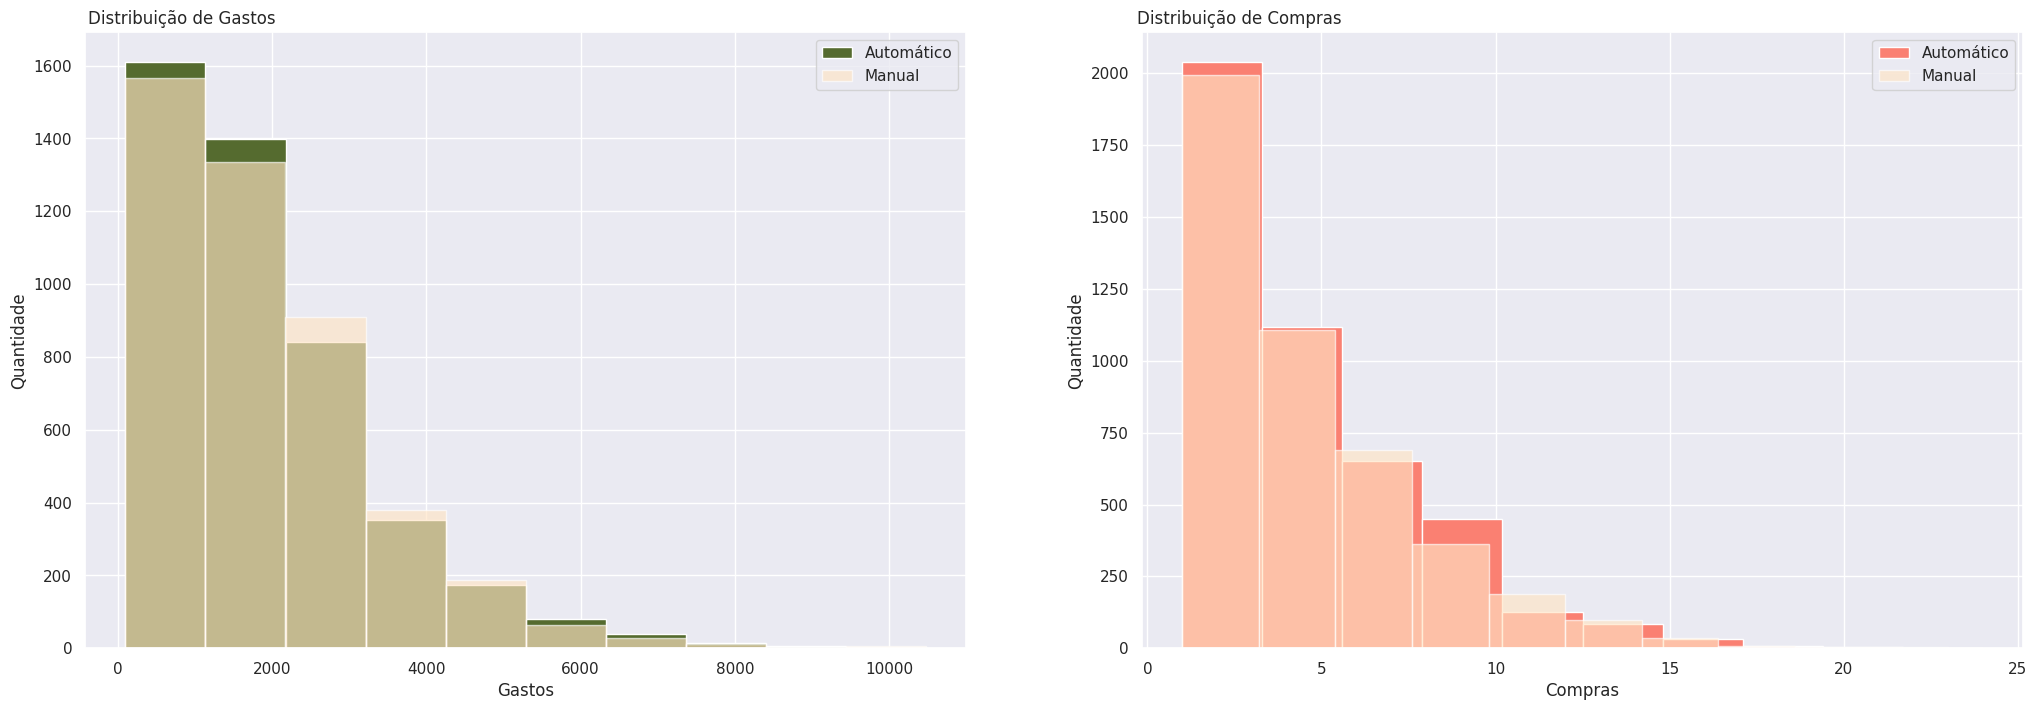

In [258]:
###Separação dos dados por grupo
ga = df_br.loc[df_br.group == 'GRP A', ['spent', 'purchases']]
gb = df_br.loc[df_br.group == 'GRP B', ['spent', 'purchases']]

### Plotagem gráfica
sns.set( rc ={'figure.figsize' : (25,8)} )
grid = GridSpec(1,2)
# Gráfico 01
plt.subplot(grid[0,0])
plt.hist(
    x = ga['spent'],
    color = 'darkolivegreen',
    bins = 10
)
plt.hist(
    x = gb['spent'],
    color='bisque',
    alpha = 0.65,
    bins = 10

)
plt.title( 'Distribuição de Gastos', x = 0.11 )
plt.xlabel( 'Gastos' )
plt.ylabel( 'Quantidade' )
plt.legend(['Automático','Manual'])

# Gráfico 02
plt.subplot(grid[0,1])
plt.hist(
    x = ga['purchases'],
    color = 'salmon',
    bins = 10

)
plt.hist(
    x = gb['purchases'],
    color='bisque',
    alpha = 0.65,
    bins = 10

)
plt.title( 'Distribuição de Compras', x = 0.11 )
plt.xlabel( 'Compras' )
plt.ylabel( 'Quantidade' )
plt.legend(['Automático','Manual']);

    Visualmente, fica claro que as médias são muito próximas e a distribuição é muito parecida. Mas, daremos continuidade no teste para descobrir o real impacto desta diferênça no negócio.

### 5.1.2 Seleção do modelo

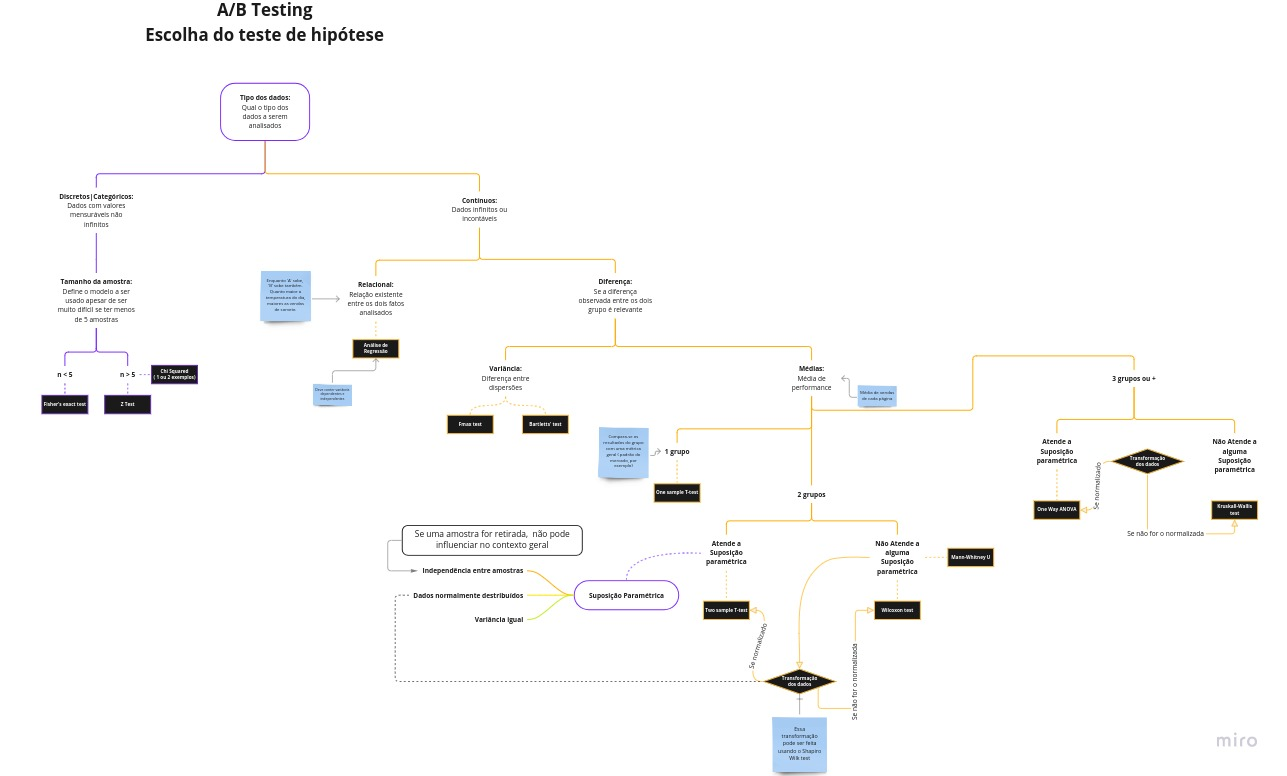

In [259]:
Image( '../img/AB_select_model.jpg' )

In [260]:
normalidade_amostral(data_raw, 'BRA', ['GRP A', 'GRP B'])


Distribuição da amostra do grupo A não é normal
Distribuição da amostra do grupo B não é normal


    - Tipo de dados            : Contínuo
    - Tamanho da amostra       : 2 grupos   
    - Atende sup. paramétricas : Não
    - - Teste Inferência       : Mann-Whitney U

### 5.1.3 Preparação dos dados

In [261]:
### Amostragem dos dados separando-os em dois grupos
sample_a = df_br.loc[df_br.group == 'GRP A', 'spent'].sample( n = sample_size )
sample_b = df_br.loc[df_br.group == 'GRP B', 'spent'].sample( n = sample_size )

print( f"A média de gastos do 'grupo A' é: {sample_a.mean():.5} (+/-) {sample_a.std():.5} " )
print( f"A média de gastos do 'grupo B' é: {sample_b.mean():.5} (+/-) {sample_b.std():.5} " )

A média de gastos do 'grupo A' é: 1936.5 (+/-) 1440.8 
A média de gastos do 'grupo B' é: 1906.0 (+/-) 1385.7 


### 5.1.4 Inferência estatística

In [262]:
t_test, p_value = mannwhitneyu( sample_a, sample_b )
print( f"P-valor: {p_value}" )

P-valor: 0.7162141325345149


In [263]:
n_signific = 0.05
if p_value > n_signific:
    print( 'Falha em rejeitar hipótese nula!' )
    print( 'Não há evidências suficiente para validar uma mudança significativa com preenchimento automático.' )
else:
    print( 'Hipótese nula rejeitada!' )    

Falha em rejeitar hipótese nula!
Não há evidências suficiente para validar uma mudança significativa com preenchimento automático.


### 5.1.5 Conclusões

In [264]:
dif_percent = ( sample_a.sum() / sample_b.sum() - 1 ) * 100
gmv_abs     = ( sample_a.sum() - sample_b.sum() )
gasto_t     = ( sample_a.sum() + sample_b.sum() )

print( 'País referência: Brasil' )
print( '---------------------------------------------------------' )
print( f"Variação percentual entre amostras de: {dif_percent:.2}%" )
print( f"Gasto amostral total: {gasto_t}" )
print( f"GMV absoluto :        {gmv_abs}" )
print( '---------------------------------------------------------' )
print( f"Tamanho amostral:       {sample_size * 2} amostras" )
### O P-valor representa a probabilidade de obter o valor da estatística de teste como o observado
print( f'P-valor:                {p_value:.2}' )
print( f'Nível de Significância: {n_signific:.2}' )

País referência: Brasil
---------------------------------------------------------
Variação percentual entre amostras de: 1.6%
Gasto amostral total: 13045064
GMV absoluto :        103660
---------------------------------------------------------
Tamanho amostral:       6790 amostras
P-valor:                0.72
Nível de Significância: 0.05


    Estatisticamente, não se pode comprovar que a diferênça percentual se dá devido a mudança implantada.

## 5.2 Espanha

### 5.2 Estatística descritiva

In [265]:
df_esp = data_raw[data_raw.country == 'ESP']

country spent                       purchases              
        count   min   max    mean     std       min max mean  std
group                                                            
GRP A     970    99  8581 1794.19 1273.60         1  19 4.36 2.93
GRP B     964    99  8980 1954.68 1332.17         1  20 4.76 3.02

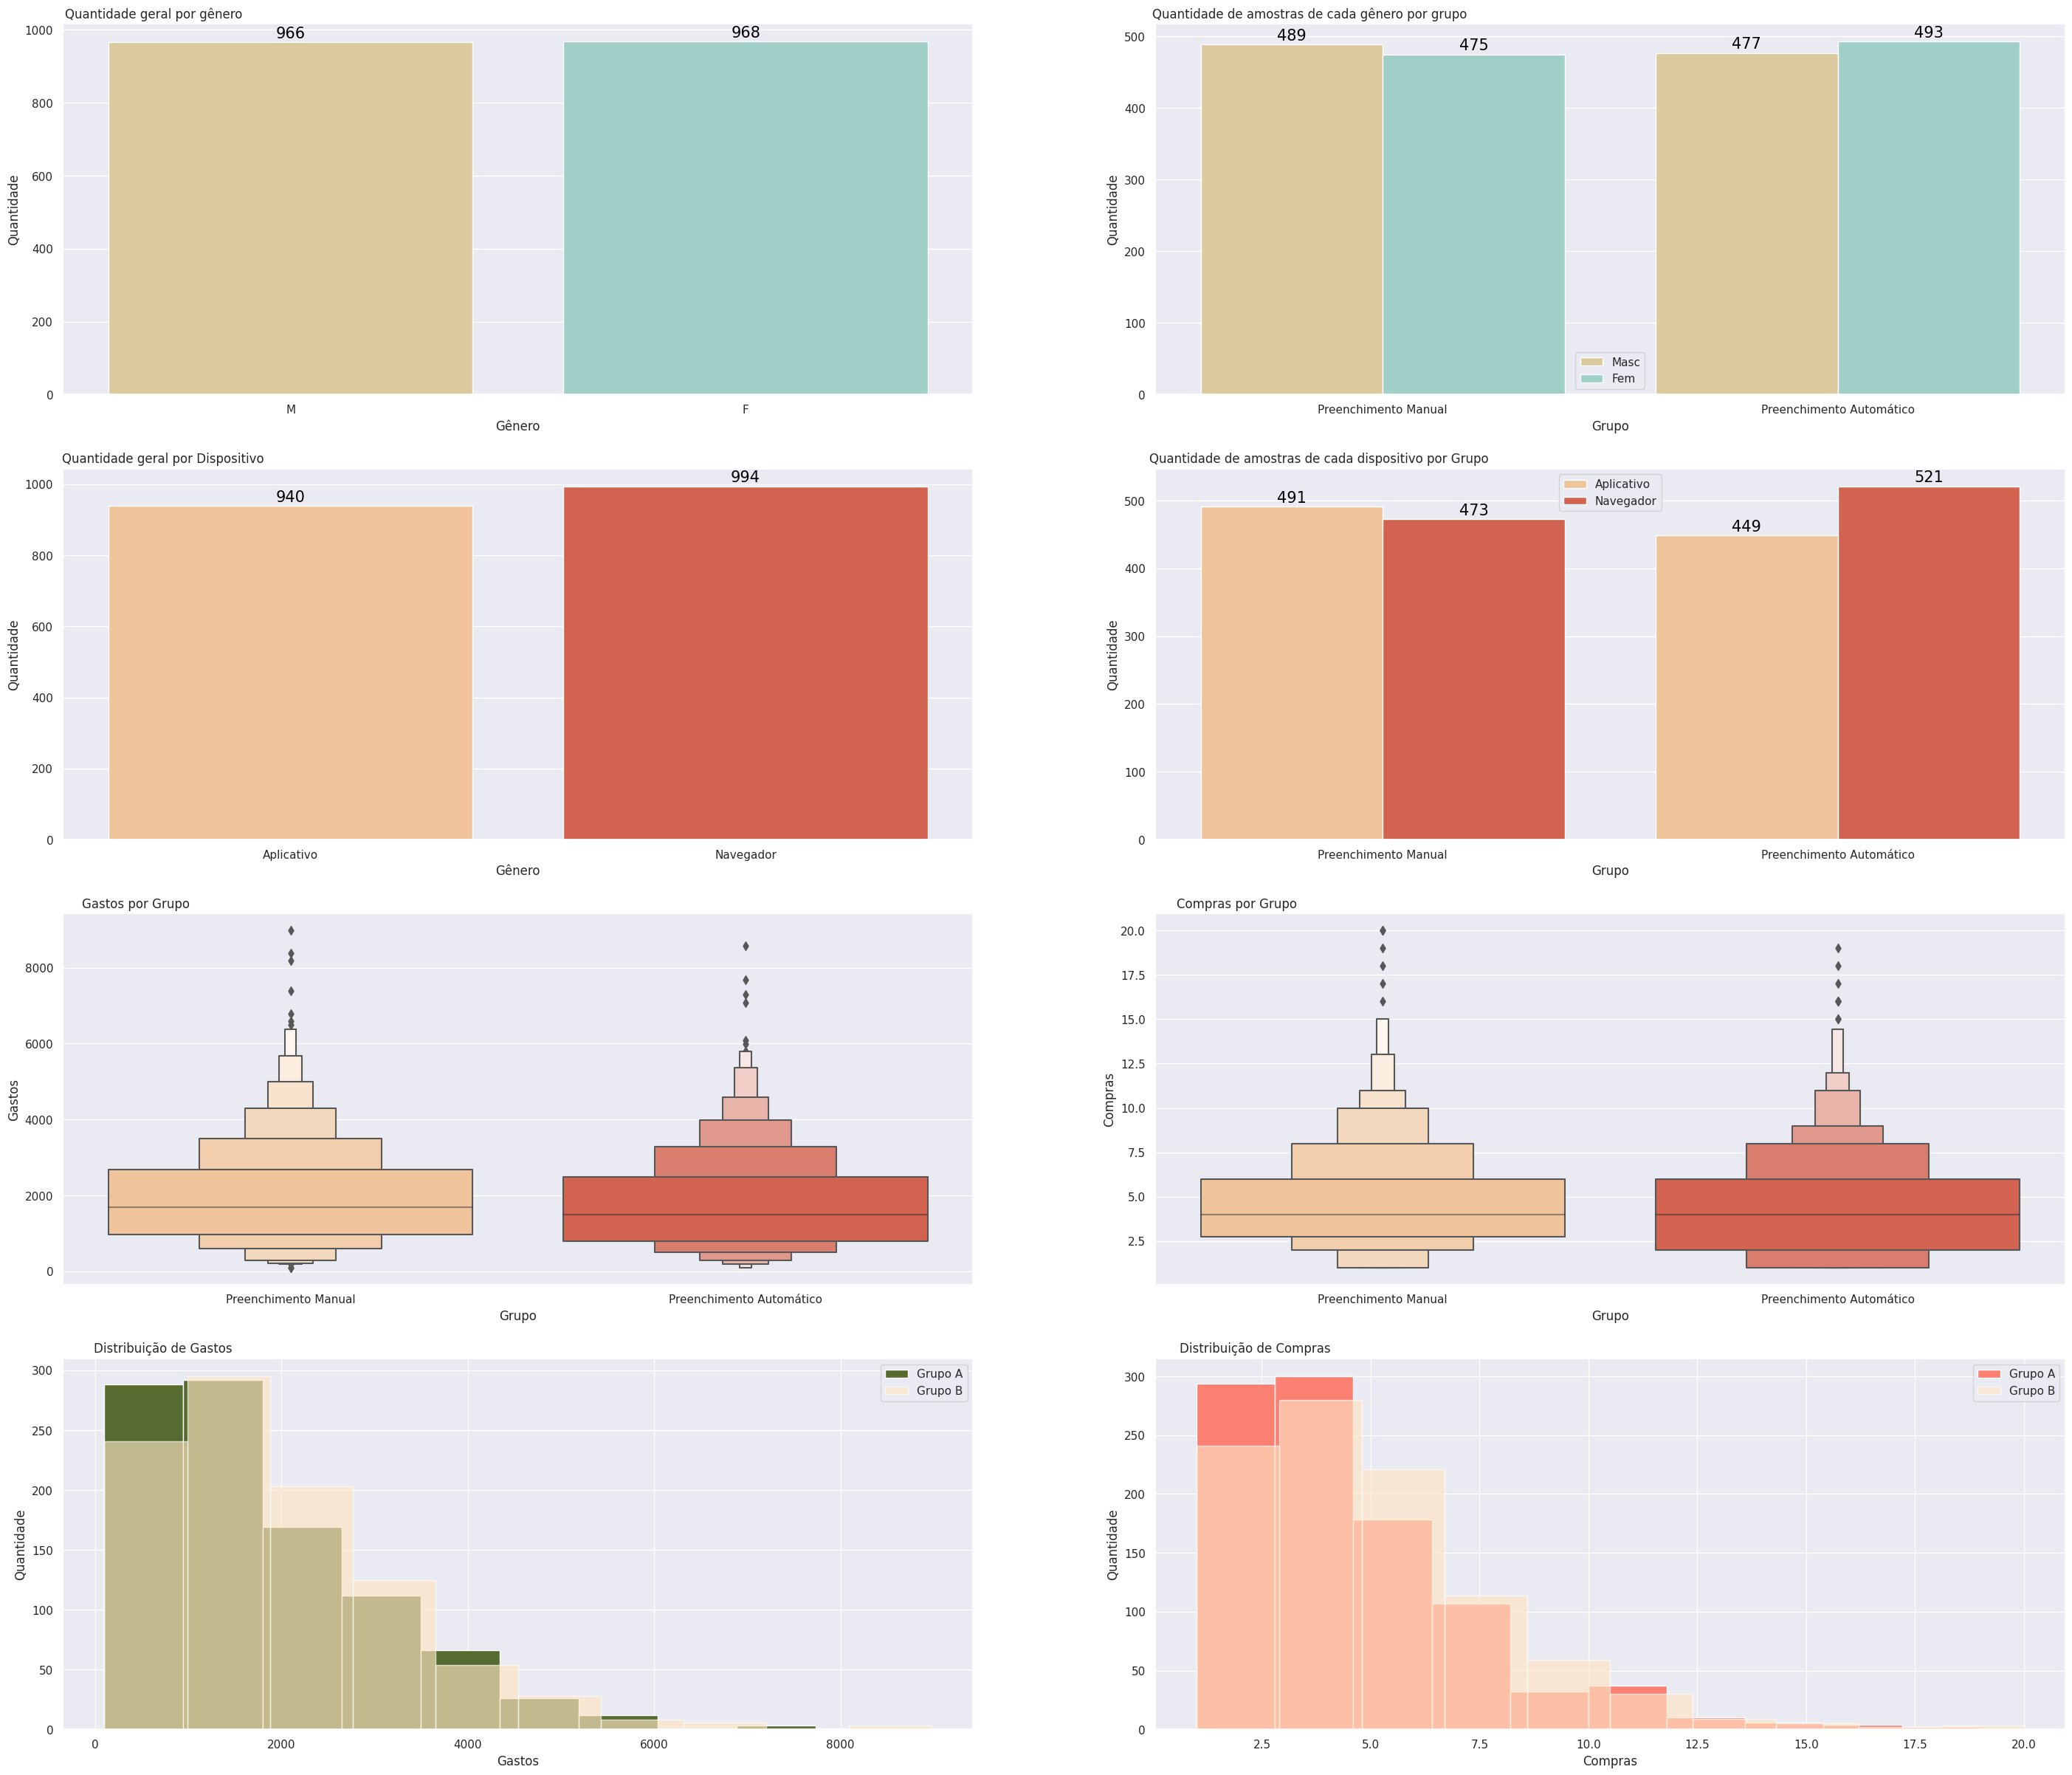

In [266]:
analise_por_pais(data_raw, 'ESP')

### 5.2.1 Definição das métricas

In [267]:
### Chamada da função encapsulada utilizando 'np.ceil' apenas para arredondar o número
sample_size, real_size = np.ceil(
    rsl.ab_testing.calculo_tamanho_amostra(
    data_raw  = data_raw,
    pais      = 'ESP',
    indicador = 0,
)
).astype(int)
print( f'Tamanho real da amostra   : {real_size}' )
print( f'Total mínimo de amostra   : {sample_size * 2}' )
print( f'Tamanho amostral por grupo: {sample_size }' )

Tamanho real da amostra   : 1934
Total mínimo de amostra   : 6094
Tamanho amostral por grupo: 3047


    Conjunto amostral insuficiente ( Com base nos padrões do estudo). Então, aumentaremos o lift a ser observado e entender o real impacto da implantação neste país.

In [268]:
### Chamada da função encapsulada utilizando 'np.ceil' apenas para arredondar o número
sample_size, real_size = np.ceil(
    rsl.ab_testing.calculo_tamanho_amostra(
    data_raw  = data_raw,
    pais      = 'ESP',
    indicador = 0,
    lift = 0.10
)
).astype(int)
print( f'Tamanho real da amostra   : {real_size}' )
print( f'Total mínimo de amostra   : {sample_size * 2}' )
print( f'Tamanho amostral por grupo: {sample_size }' )

Tamanho real da amostra   : 1934
Total mínimo de amostra   : 1526
Tamanho amostral por grupo: 763


### 5.2.2 Seleção do modelo

In [269]:
normalidade_amostral(data_raw, 'ESP', ['GRP A', 'GRP B'])

Distribuição da amostra do grupo A não é normal
Distribuição da amostra do grupo B não é normal


    - Tipo de dados            : Contínuo
    - Tamanho da amostra       : 2 grupos   
    - Atende sup. paramétricas : Não
    - - Teste Inferência       : Mann-Whitney U

### 5.2.3 Preparação dos dados

In [270]:
### Amostragem dos dados separando-os em dois grupos
sample_esp_a = df_esp.loc[df_esp.group == 'GRP A', 'spent'].sample( n = sample_size )
sample_esp_b = df_esp.loc[df_esp.group == 'GRP B', 'spent'].sample( n = sample_size )

print( f"A média de gastos do 'grupo A' é: {sample_esp_a.mean():.5} (+/-) {sample_esp_a.std():.5} " )
print( f"A média de gastos do 'grupo B' é: {sample_esp_b.mean():.5} (+/-) {sample_esp_b.std():.5} " )

A média de gastos do 'grupo A' é: 1773.1 (+/-) 1269.9 
A média de gastos do 'grupo B' é: 1964.8 (+/-) 1351.9 


### 5.3.4 Inferência estatística

In [271]:
t_test, p_values = mannwhitneyu( sample_esp_a, sample_esp_b )
if p_value > n_signific:
    print( 'Falha em rejeitar hipótese nula!' )
    print( 'Não há evidências suficiente para validar uma mudança significativa com preenchimento automático.' )
else:
    print( 'Hipótese nula rejeitada!' )    

Falha em rejeitar hipótese nula!
Não há evidências suficiente para validar uma mudança significativa com preenchimento automático.


### 5.3.5 Conclusão

In [272]:
dif_percent = ( sample_esp_a.sum() / sample_esp_b.sum() - 1 ) * 100
gmv_abs     = ( sample_esp_a.sum() - sample_esp_b.sum() )
gasto_t     = ( sample_esp_a.sum() + sample_esp_b.sum() )

print( 'País referência: Brasil' )
print( '---------------------------------------------------------' )
print( f"Variação percentual entre amostras de: {dif_percent:.2}%" )
print( f"Gasto amostral total: {gasto_t}" )
print( f"GMV absoluto :        {gmv_abs}" )
print( '---------------------------------------------------------' )
print( f"Tamanho amostral:       {sample_size * 2} amostras" )
### O P-valor representa a probabilidade de obter o valor da estatística de teste como o observado
print( f'P-valor:                {p_value:.2}' )
print( f'Nível de Significância: {n_signific:.2}' )

País referência: Brasil
---------------------------------------------------------
Variação percentual entre amostras de: -9.8%
Gasto amostral total: 2852059
GMV absoluto :        -146251
---------------------------------------------------------
Tamanho amostral:       1526 amostras
P-valor:                0.72
Nível de Significância: 0.05


    Nota-se que na Espanha, houve uma diminuição geral nas vendas quando o modelo utilizado era o de preenchimento automático. 
    Contudo, não se pode afirmar que isso se deve ao modelo de preenchimento automático, mesmo assim não aconselharia a implantação do modelo na Espanha.